# A finite element analysis of elastic contact problem

In this example of a deformable ``cylinder 1`` enters in contact with a deformable  ``cylinder 2``. We use here python interface, translate this program for another interface or in C++ is easy (see the previous example).

![Kontakt_paralleler_Zylinder](https://upload.wikimedia.org/wikipedia/commons/e/ef/Kontakt_paralleler_Zylinder.jpg)

## The problem setting

Let $\Omega^{1} \subset \mathbb{R}^{2}$ be the reference of a 2D cylinder 1 and $\Omega^{2} \subset \mathbb{R}^{2}$ the reference configuration of a deformable cylinder. We consider small deformation of these two bodies (linearized elasticity) and the contact between them.

## Building the program

Let us begin by loading Getfem and fixing the parameters of the problem

In [1]:
import getfem as gf
import numpy as np
import pyvista as pv
from pyvirtualdisplay import Display

E = E1 = E2 = 200000.0  # Yong Modulus (MPa)
nu1 = nu2 = 0.3  # Poisson ratio
clambda1 = E1 * nu1 / ((1 + nu1) * (1 - 2 * nu1))  # First Lame coefficient (MPa)
clambda2 = E2 * nu2 / ((1 + nu2) * (1 - 2 * nu2))  # First Lame coefficient (MPa)
cmu1 = E1 / (2 * (1 + nu1))  # Second Lame coefficient (MPa)
cmu2 = E2 / (2 * (1 + nu2))  # Second Lame coefficient (MPa)
clambdastar1 = (
    2 * clambda1 * cmu1 / (clambda1 + 2 * cmu1)
)  # Lame coefficient for Plane stress (MPa)
clambdastar2 = (
    2 * clambda2 * cmu2 / (clambda2 + 2 * cmu2)
)  # Lame coefficient for Plane stress (MPa)

elements_degree = 2  # Degree of the finite element methods

applied_force = 200.0  # Force at the top boundary (N)

gamma0 = 1.0 / E  # Augmentation parameter for the augmented Lagrangian

We consider that the radius of the two cylinder is 5mm.
We load the mesh of the cylinder using the load of a mesh from a GetFEM ascii mesh file (see the documentation of the Mesh object in the python interface).

In [2]:
# !gmsh hertz.mesh -f msh2 -save -o hertz.msh
mesh = gf.Mesh("import", "gmsh", "hertz.msh")
mesh.translate([0.0, 5.0])
P = mesh.pts()

# cvid1
c1 = P[1, :] >= 0.0
pid1 = np.compress(c1, list(range(0, mesh.nbpts())))
cvid1 = mesh.cvid_from_pid(pid1)

# cvid2
c2 = P[1, :] <= 0.0
pid2 = np.compress(c2, list(range(0, mesh.nbpts())))
cvid2 = mesh.cvid_from_pid(pid2)

mesh1 = gf.Mesh("clone", mesh)
mesh1.del_convex(cvid2)
mesh1.export_to_vtk("mesh1.vtk")

mesh2 = gf.Mesh("clone", mesh)
mesh2.del_convex(cvid1)
mesh2.export_to_vtk("mesh2.vtk")

The result is the following

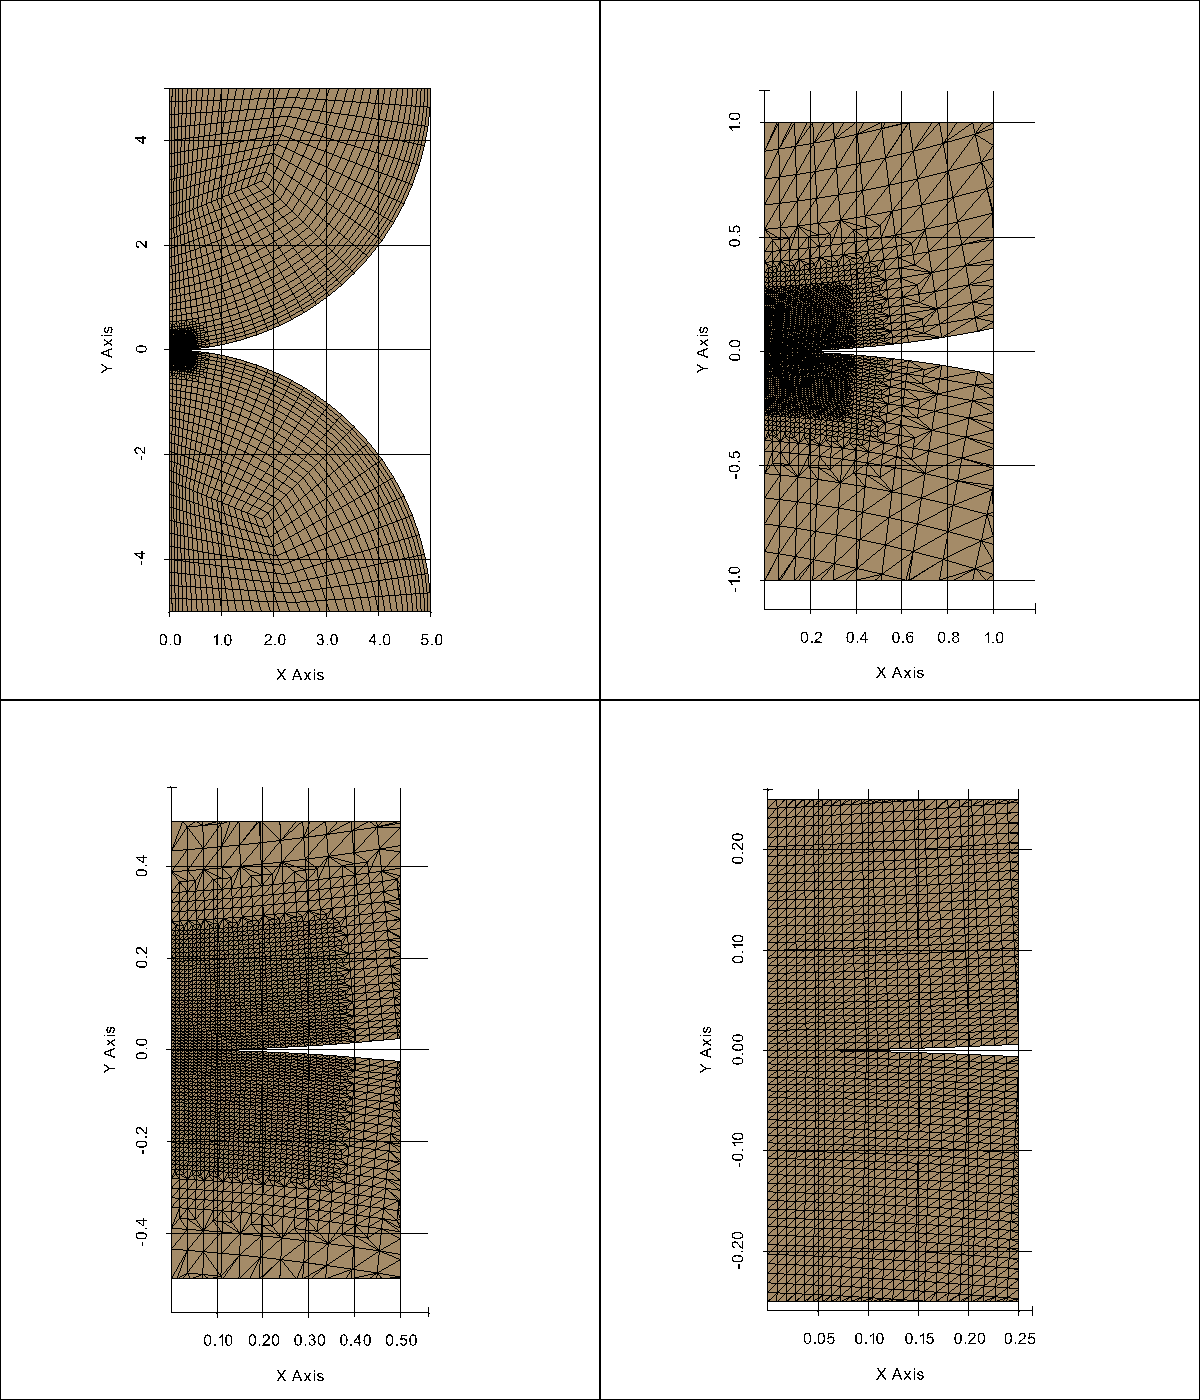

In [3]:
display = Display(visible=0, size=(1024, 1024))
display.start()

m1 = pv.read("mesh1.vtk")
m2 = pv.read("mesh2.vtk")
p = pv.Plotter(shape=(2, 2))
p.subplot(0, 0)
p.add_mesh(m1, show_edges=True)
p.add_mesh(m2, show_edges=True)
p.show_grid()
p.subplot(0, 1)
p.add_mesh(
    m1.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True
)
p.show_grid()
p.subplot(1, 0)
p.add_mesh(
    m1.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True
)
p.show_grid()
p.subplot(1, 1)
p.add_mesh(
    m1.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True
)
p.show_grid()
p.show(screenshot="mesh.png", window_size=[1200, 1400], cpos="xy")

display.stop()

## Boundary selection

We have to select the different parts of the boundary where we will set some boundary conditions, namely the boundary of the rim (in order to apply a force and the fact that the rim is rigid), the contact boundary of the wheel and the bottom boundary of the foundation that we will assume clamped.

In [4]:
# Top boundary
fb1 = mesh1.outer_faces_with_direction([0.0, 1.0], 0.01)
# Left boundary
fb2 = mesh1.outer_faces_with_direction([-1.0, 0.0], 0.01)
fb3 = mesh2.outer_faces_with_direction([-1.0, 0.0], 0.01)
# Bottom Boundary
fb4 = mesh2.outer_faces_with_direction([0.0, -1.0], 0.01)
# Contact boundary
fb5 = mesh1.outer_faces_with_direction([0.0, -1.0], np.pi / 6.0)
fb6 = mesh2.outer_faces_with_direction([0.0, 1.0], np.pi / 6.0)

TOP_BOUND = 1
LEFT_BOUND = 2
BOTTOM_BOUND = 3
CONTACT_BOUND = 4

mesh1.set_region(TOP_BOUND, fb1)
mesh1.set_region(LEFT_BOUND, fb2)
mesh2.set_region(LEFT_BOUND, fb3)
mesh2.set_region(BOTTOM_BOUND, fb4)
mesh1.set_region(CONTACT_BOUND, fb5)
mesh2.set_region(CONTACT_BOUND, fb6)

Note that the command `mesh1.outer_faces_with_direction([0., -1.0], np.pi/6)` allows to select all the faces having a unit outward normal having an angle less or equal to `np.pi/6` with the vector `[0., -1.0]`.

## Definition of finite elements methods and integration method
We define mfu1, mfu2 two finite element methods which will approximate the displacements in the `cylinder1` and `cylinder2`.
`mflambda` is finite element method to approximate a multiplier to take into account the rigidity of the rim, `mflambda_C` is to approximate the contact multiplier (contact pressure) and `mfvm1`, `mfvm2` will be used to interpolate the Von Mises stresses of the wheel and the foundation for post-processing.
`mim1`, `mim2` are two integration methods on the `cylinder1` and the `cylinder2`.

In [5]:
mfu1 = gf.MeshFem(mesh1, 2)
mfu1.set_classical_fem(elements_degree)
mflambda = gf.MeshFem(mesh1, 2)
mflambda.set_classical_fem(elements_degree - 1)
mflambda_C = gf.MeshFem(mesh1, 1)
mflambda_C.set_classical_fem(elements_degree - 1)
mfu2 = gf.MeshFem(mesh2, 2)
mfu2.set_classical_fem(elements_degree)
mfvm1 = gf.MeshFem(mesh1, 1)
mfvm1.set_classical_discontinuous_fem(elements_degree)
mfvm2 = gf.MeshFem(mesh2, 1)
mfvm2.set_classical_discontinuous_fem(elements_degree)
mim1 = gf.MeshIm(mesh1, pow(elements_degree, 2))
mim2 = gf.MeshIm(mesh2, pow(elements_degree, 2))

## Model definition

We use a real model and declare the two variables which will represent the displacements:

In [6]:
md = gf.Model("real")
md.add_fem_variable("u1", mfu1)
md.add_fem_variable("u2", mfu2)

## Linearized elasticity bricks

We add the Lamé coefficients as data of the model and add a linearized elasticity brick for the wheel and the foundation:

In [7]:
md.add_initialized_data("cmu1", [cmu1])
md.add_initialized_data("cmu2", [cmu2])
md.add_initialized_data("clambdastar1", [clambdastar1])
md.add_initialized_data("clambdastar2", [clambdastar2])
md.add_isotropic_linearized_elasticity_brick(mim1, "u1", "clambdastar1", "cmu1")
md.add_isotropic_linearized_elasticity_brick(mim2, "u2", "clambdastar2", "cmu2")

1

## Clamped condition at the bottom and left boundary

We prescribed the displacement at bottom face of the foundation to vanish, for instance with a multiplier with the add of the following brick:

In [8]:
md.add_Dirichlet_condition_with_multipliers(
    mim2, "u2", elements_degree - 1, BOTTOM_BOUND
)

2

In [9]:
md.add_Dirichlet_condition_with_multipliers(
    mim1, "u1", elements_degree - 1, TOP_BOUND
)

3

## Contact condition (use of interpolate transformations)

Now, let us see how to prescribed the contact condition between the two structures.
It is possible to use predefined bricks (see [Small sliding contact with friction bricks](https://getfem.readthedocs.io/en/latest/userdoc/model_contact_friction.html#ud-model-contact-friction) for small deformation/small sliding contact and [Large sliding/large deformation contact with friction bricks](https://getfem.readthedocs.io/en/latest/userdoc/model_contact_friction_large_sliding.html#ud-model-contact-friction-large) for large deformation/large sliding contact).
However, we will see here how to directly prescribe a contact condition using an augmented Lagrangian formulation and the interpolate transformations.

For small deformation contact, the correspondence between points of one contact surface to the other have to be described on the reference configuration and is not evolving, which is of course simpler but is an approximation.

We consider that the contact boundary of the wheel is the slave one and we have to describe the transformation from the contact boundary of the wheel to the contact boundary of the foundation.
This is quite simple here, since the contact boundary of the foundation corresponds to a vanishing vertical coordinate.
So we define the transformation

$$
X \longmapsto (X(1), 0)
$$

where $X$ is the vector of coordinates of the point. We add this transformation to the model with the command

In [10]:
md.add_interpolate_transformation_from_expression("Proj1", mesh1, mesh2, "[X(1);0]")

As a consequence, it will be possible to use this transformation, from the mesh of the wheel to the mesh of the foundation, into GWFL expressions.
Notes that this is here a very simple constant expression.
More complex expressions depending on the data or even the variables of the model can be used.
If the expression of a transformation depends on the variable of the model, the tangent linear system will automatically takes into account this dependence (see [Interpolate transformations](https://getfem.readthedocs.io/en/latest/userdoc/gasm_high.html#ud-gasm-high-transf) for more details). 
Note also that transformation corresponding to a large sliding contact and automatically searching for the correspondence between contact boundaries exist in GetFEM (see [Integral contact brick with raytrace](https://getfem.readthedocs.io/en/latest/userdoc/model_contact_friction_large_sliding.html#ud-model-contact-friction-large-hlgav)).

Using the defined transformation, we can write an integral contact condition using an augmented Lagrangian formulation (see [Small sliding contact with friction bricks](https://getfem.readthedocs.io/en/latest/userdoc/model_contact_friction.html#ud-model-contact-friction) for more details).
The corresponding term (to be added to the rest of the weak formulation) reads:

$$
  \cdots +  \int_{\Gamma_c} \lambda_N(X) (\delta_{u^1}(X)-\delta_{u^2}(\Pi(X)))\cdot n d\Gamma \\
  -   \int_{\Gamma_c} \left(\lambda_N(X) + \left(\lambda_N(X) + \dfrac{1}{h_T\gamma_0}((X + u^1(X))\cdot n - (\Pi(X) - u^2(\Pi(X)))\cdot n\right)_-\right)\delta_{\lambda_N}(X) d\Gamma = 0 ~~~~ \forall \delta_{\lambda_N}, \forall \delta_{u^1}, \forall \delta_{u^2},
$$

where $\Gamma_c$ is the slave contact boundary, $\lambda_N$ is the contact multiplier (contact pressure), $h_T$ is the radius of the element, $\Pi$ is the transformation, $n$ is the outward normal vector to the master contact boundary (here $n = (0,1)$), $\gamma_0$ is an augmentation parameter, $(\cdot)_-:I\hspace{-0.2em}R\rightarrow I\hspace{-0.2em}R_+$ is the negative part and $\delta_{\lambda_N}, \delta_{u^1}, \delta_{u^2}$ are the test  functions corresponding to $\lambda_N, u^1, u^2$, respectively.

Using GWFL, the contact condition can be added by:

In [11]:
# md.add_initialized_data("gamma0", [gamma0])
# md.add_filtered_fem_variable("lambda1", mflambda_C, CONTACT_BOUND)
# md.add_nonlinear_term(
#     mim1,
#     "lambda1*(Test_u1.[0;1])" "-lambda1*(Interpolate(Test_u2,Proj1).[0;1])",
#     CONTACT_BOUND,
# )
# md.add_nonlinear_term(
#     mim1,
#     "-(gamma0*element_size)"
#     "*(lambda1 + neg_part(lambda1+(1/(gamma0*element_size))"
#     "*((u1-Interpolate(u2,Proj1)+X-Interpolate(X,Proj1)).[0;1])))*Test_lambda1",
#     CONTACT_BOUND,
# )

## Prescribing the rigidity of the rim and the vertical force
We have now to prescribe the rigidity of the rim. This is a non-standard condition, since we do not know a priori what will be the vertical displacement of the rim. We can use an additional unknown for that vertical displacement. We add an additional fixed size variable `alpha_D` (which mean that it does not a finite element field) of size 1 with

In [12]:
# md.add_variable("alpha_D", 1)

We need a multiplier to prescribe the displacement on the rim boundary:

In [13]:
# md.add_filtered_fem_variable("lambda_D", mflambda, TOP_BOUND)

This multiplier represents the boundary stress that is necessary to prescribe the vertical displacement to be $(0, -\alpha_D)$.
The constraint we want to apply on this multiplier is that its integral over the rim boundary is the vertical force we want to apply.
The corresponding weak formulation term to be added to the rest of the weak formulation reads

$$
\cdots + \int_{\Gamma_D} -\lambda_D.\delta_{u^1} + ((0, \alpha_D) - u^1).\delta_{\lambda_D} + (\lambda_D.(0,1) + F)\delta_{\alpha_D} d\Gamma = 0,
$$

where $\Gamma_D$ is the rim boundary, $F$ is the applied density of force.

This could be added to the model with GWFL:

In [14]:
# md.add_initialized_data("F", [applied_force / (5.0 * 2)])
# md.add_linear_term(
#     mim1,
#     "-lambda_D.Test_u1 + (alpha_D*[0;1]-u1).Test_lambda_D"
#     " + (lambda_D.[0;1]+F)*Test_alpha_D",
#     TOP_BOUND,
# )

For more robustness, a small penalization on `alpha_D` can be added


In [15]:
# md.add_linear_term(mim1, "1E-6*alpha_D*Test_alpha_D")

Note that the fixed size variable `alpha_D` is linked to each points of the rim boundary.
This means that the line of the tangent matrix corresponding to `alpha_D` may have a lot of nonzero components.
This is why such a use of fixed size variable have to be done with care.

## Model solve
We can now solve our problem with:

In [16]:
md.solve("max_res", 1e-9, "max_iter", 100, "noisy")

(0, 1)

Note that in some configuration, it is preferable to use a more basic line search than the default one:

## Export the solution

Now the code to export the solution with the VonMises stress:

In [17]:
U1 = md.variable("u1")
U2 = md.variable("u2")
# VM1 = md.compute_isotropic_linearized_Von_Mises_or_Tresca(
#     "u1", "clambdastar", "cmu", mfvm1
# )
# VM2 = md.compute_isotropic_linearized_Von_Mises_or_Tresca(
#     "u2", "clambdastar", "cmu", mfvm2
# )

mfvm1.export_to_vtk(
    "displacement_with_von_mises1.vtk",
#     mfvm1,
#     VM1,
#     "Von Mises Stresses",
    mfu1,
    U1,
    "Displacements",
)

mfvm2.export_to_vtk(
    "displacement_with_von_mises2.vtk",
#     mfvm2,
#     VM2,
#     "Von Mises Stresses",
    mfu2,
    U2,
    "Displacements",
)

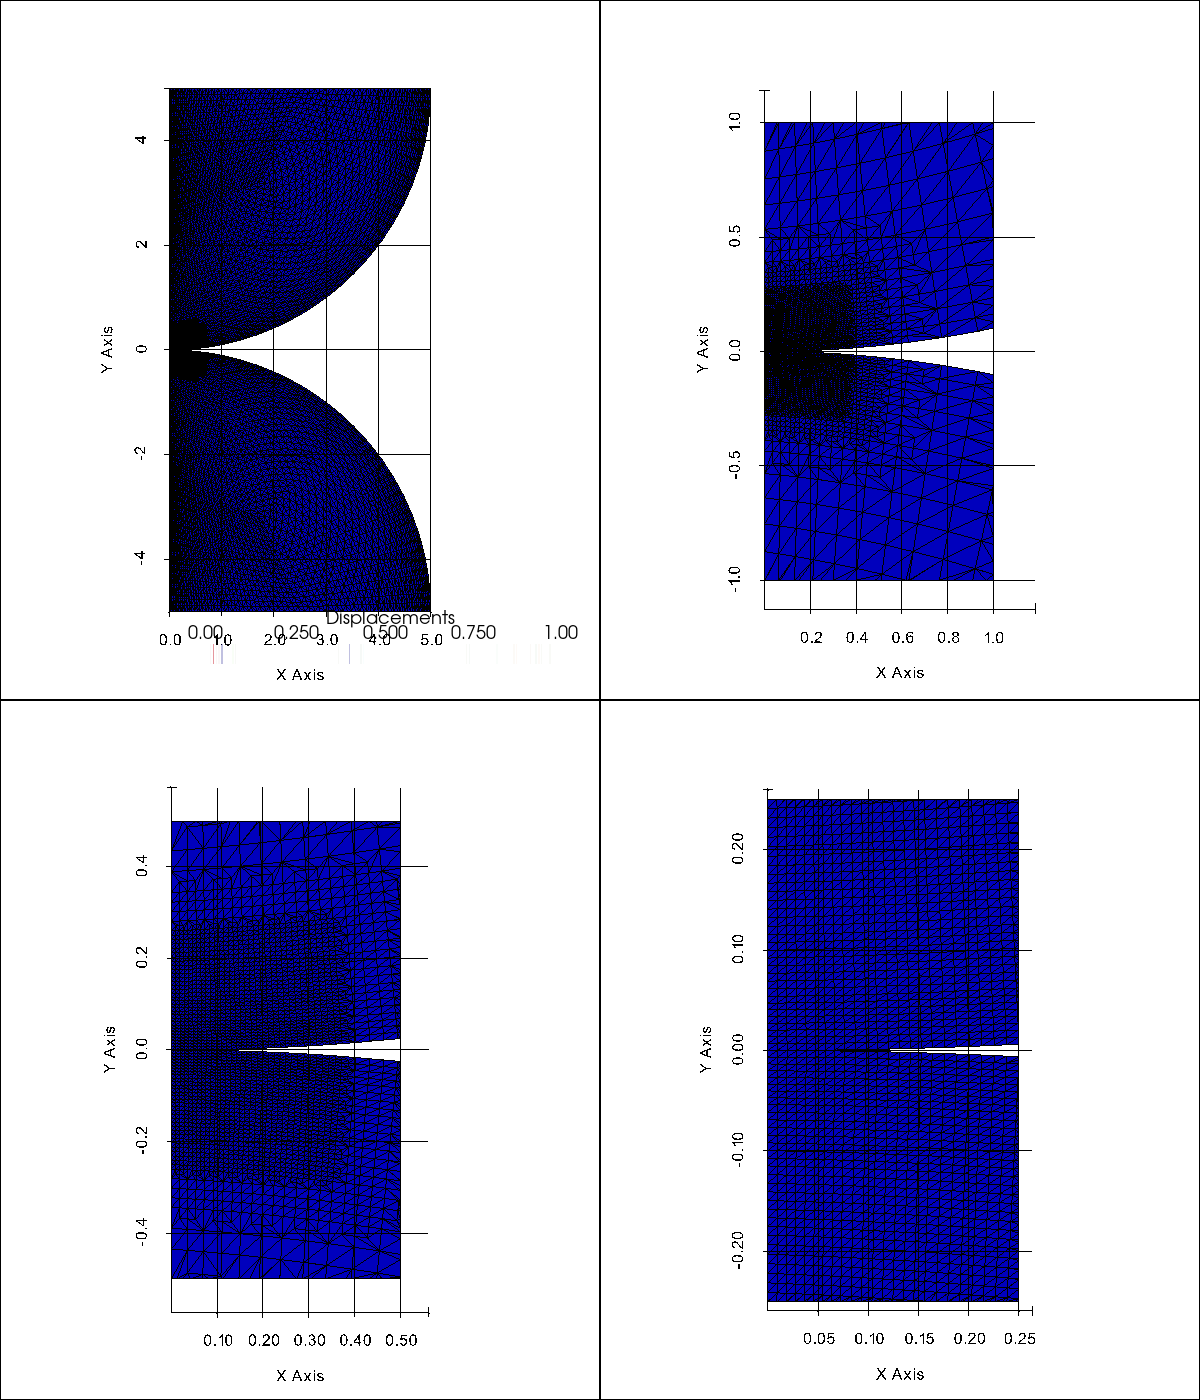

In [18]:
display = Display(visible=0, size=(1024, 1024))
display.start()

m1 = pv.read("displacement_with_von_mises1.vtk")
m2 = pv.read("displacement_with_von_mises2.vtk")
p = pv.Plotter(shape=(2, 2))
p.subplot(0, 0)
p.add_mesh(m1, show_edges=True)
p.add_mesh(m2, show_edges=True)
p.show_grid()
p.subplot(0, 1)
p.add_mesh(
    m1.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True
)
p.show_grid()
p.subplot(1, 0)
p.add_mesh(
    m1.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True
)
p.show_grid()
p.subplot(1, 1)
p.add_mesh(
    m1.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True
)
p.add_mesh(
    m2.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True
)
p.show_grid()
p.show(screenshot="mesh.png", window_size=[1200, 1400], cpos="xy")

display.stop()